In [1]:
import pickle
import numpy as np
import os
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("../input/smart-reply-sentence-similarity-using-annoy/input_texts.pickle", 'rb') as handle:
    input_texts = pickle.load(handle)

In [3]:
tqdm.pandas()
df = pd.read_csv("../input/smart-reply-clean-annoy-input-similarity/input_similarity_matrix_float.csv", header=None, dtype=np.float64)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21851,21852,21853,21854,21855,21856,21857,21858,21859,21860
0,0.000000,1.141314,0.739278,1.065237,1.364808,1.361341,1.267907,0.358515,0.995389,0.855678,...,1.321036,0.768110,1.311950,1.388766,1.245038,1.167628,0.953615,1.255388,0.805379,1.199280
1,1.141314,0.000000,1.208509,1.245685,1.383762,1.216114,1.269372,0.953707,0.791277,1.128460,...,1.309301,1.103240,1.229787,1.379067,1.325001,1.325661,1.295232,1.293990,1.191827,0.932619
2,0.739278,1.208509,0.000000,0.720378,1.368834,1.256209,0.986893,0.763642,0.929416,1.020079,...,0.967532,0.912500,1.335236,1.114811,0.965196,1.070835,1.089031,1.333803,0.838690,1.308988
3,1.065237,1.245685,0.720378,0.000000,1.194829,1.380972,0.619906,1.102341,0.900154,1.231292,...,0.440970,1.094629,1.365876,1.363651,1.253728,1.320156,1.246677,1.373108,1.063383,1.354012
4,1.364808,1.383762,1.368834,1.194829,0.000000,1.392209,1.400194,1.392744,1.395235,1.354218,...,1.408263,1.351133,1.352064,1.384548,1.360818,1.335063,1.395140,1.375792,0.943220,1.365638


In [4]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,21851,21852,21853,21854,21855,21856,21857,21858,21859,21860
count,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,...,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000,21861.000000
mean,1.083888,1.201261,1.085291,1.175782,1.291108,1.261123,1.248549,1.108750,1.171484,1.142644,...,1.269586,1.093505,1.228470,1.303261,1.254825,1.199242,1.226880,1.213700,1.087174,1.179703
std,0.324403,0.213355,0.252623,0.233548,0.210289,0.143902,0.192834,0.332814,0.173752,0.199077,...,0.245782,0.216465,0.261838,0.201484,0.198997,0.135470,0.182171,0.256924,0.235537,0.137723
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.925392,1.166083,0.896094,1.111268,1.312205,1.202187,1.224984,0.952466,1.043393,0.988512,...,1.284034,0.921132,1.233897,1.328385,1.247864,1.146969,1.112872,1.167828,0.899953,1.083674
50%,1.233301,1.255940,1.135430,1.238246,1.371312,1.292761,1.322427,1.250734,1.195318,1.185107,...,1.373946,1.131893,1.326728,1.377813,1.309798,1.229907,1.294332,1.307434,1.123368,1.207010
75%,1.323262,1.337622,1.311057,1.347634,1.389380,1.364250,1.363876,1.362786,1.327785,1.317199,...,1.392697,1.280205,1.373387,1.395231,1.369619,1.289380,1.372815,1.375675,1.299468,1.289857
max,1.412279,1.412751,1.412421,1.413490,1.413898,1.413526,1.413712,1.413782,1.412738,1.412578,...,1.413931,1.411917,1.413705,1.413951,1.413142,1.409784,1.413043,1.413776,1.412472,1.413265


In [5]:
input_similarity_matrix = df

In [6]:
# finding 10th neighbour distance to sentence 1
input_similarity_matrix.iloc[1].nsmallest(10).iloc[10-1]

0.199556291103363

In [7]:
# extending logic to all rows
def sort_and_select_10_neigh_dist(row):
    return row.nsmallest(10).iloc[10-1]

neighbor_10_dist = input_similarity_matrix.apply(sort_and_select_10_neigh_dist, axis = 1) 

In [8]:
neighbor_10_dist.describe()

count    21861.000000
mean         0.323176
std          0.199979
min          0.000000
25%          0.163233
50%          0.303145
75%          0.462683
max          1.143020
dtype: float64

In [9]:
for x in list(input_similarity_matrix.nsmallest(10, 1).index.astype(int)):
    print(input_texts[x], " - Similarity Score :", input_similarity_matrix[x][1]) 

yes he even won a hardcore cha cha championship in 1958  - Similarity Score : 0.0
of course. he has made good movies  - Similarity Score : 0.1114737167954444
i will not. unless i am speaking about myself.  - Similarity Score : 0.1163508221507072
yeah its like the 70s show and days like these.  - Similarity Score : 0.161270722746849
that's too bad i wonder what a radio cooking show would sound like anyways.  - Similarity Score : 0.1695958822965622
wow lol. did you ever participate in the burger king promotion  - Similarity Score : 0.1869672685861587
right. did you ever watch 3rd rock fromthe sun seinfeld friends or frasier  - Similarity Score : 0.1881543844938278
yeah. do you know what kickball is also called in canada  - Similarity Score : 0.1886741071939468
i have a golden retriever big dog lots of trouble  - Similarity Score : 0.1991804838180542
no i rather watch the movie than read.  - Similarity Score : 0.199556291103363


In [10]:
# using 40th percentile value as appropriate distance for 10th neighbour
eps_10 = neighbor_10_dist.quantile(0.99)
print(eps_10)

0.8194868087768558


In [11]:
eps_nums = list()
eps_num_clusters = list()
eps_num_noise = list()
trial_eps = np.linspace(0, neighbor_10_dist.quantile(1.0), num=100)

for eps_num in trial_eps:
    
    if eps_num > 0:    
        if eps_num > 0.3:
            break
            
        print("Taking EPS as", eps_num)
        
        # Compute DBSCAN
        db = DBSCAN(eps=eps_num, min_samples=5, metric="precomputed", n_jobs=4).fit(input_similarity_matrix)
        #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        #core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        eps_nums.append(eps_num)
        eps_num_clusters.append(n_clusters_)
        eps_num_noise.append(n_noise_)

        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("-----------")
        
        if n_clusters_ == 1:
            print("Stopping..")
            # least number of clusters
            break

Taking EPS as 0.011545659315706504
Estimated number of clusters: 66
Estimated number of noise points: 21018
-----------
Taking EPS as 0.023091318631413008
Estimated number of clusters: 84
Estimated number of noise points: 20592
-----------
Taking EPS as 0.034636977947119514
Estimated number of clusters: 83
Estimated number of noise points: 20111
-----------
Taking EPS as 0.046182637262826016
Estimated number of clusters: 78
Estimated number of noise points: 19653
-----------
Taking EPS as 0.05772829657853252
Estimated number of clusters: 84
Estimated number of noise points: 19093
-----------
Taking EPS as 0.06927395589423903
Estimated number of clusters: 80
Estimated number of noise points: 18580
-----------
Taking EPS as 0.08081961520994553
Estimated number of clusters: 80
Estimated number of noise points: 18041
-----------
Taking EPS as 0.09236527452565203
Estimated number of clusters: 78
Estimated number of noise points: 17527
-----------
Taking EPS as 0.10391093384135854
Estimated 

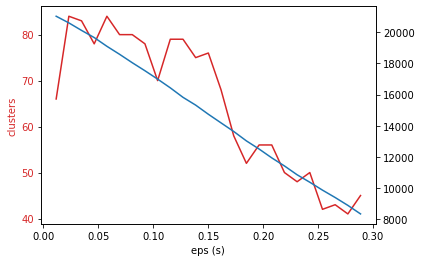

In [12]:
from matplotlib.pyplot import figure
#figure(num=None, figsize=(15, 6), dpi=80)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('eps (s)')
ax1.set_ylabel('clusters', color=color)
ax1.plot(eps_nums, eps_num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

ax2.plot(eps_nums, eps_num_noise)
plt.show()

In [13]:
print("Taking EPS as", 0.06)
# Compute DBSCAN
db = DBSCAN(eps=0.006, min_samples=5, metric="precomputed", n_jobs=4).fit(input_similarity_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Taking EPS as 0.06
Estimated number of clusters: 62
Estimated number of noise points: 21149


In [14]:

from collections import Counter

for unique_label in set(labels):
    
    class_member_mask = (labels == unique_label)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(np.array(input_texts)[class_member_mask])
    print("-------------------------------------")
    #print(Counter(class_member_mask).keys()) # equals to list(set(words))
    #Counter(words).values() # counts the elements' frequency


In cluster 0 found 15 points
Samples
['you as well..' 'you as well' 'you as well ...' 'you as well'
 'you as well.' 'you as well.' 'you as well.' 'you as well.' 'you as well'
 'you as well' 'you as well.' 'you as well.' 'you as well.' 'you as well.'
 'you as well']
-------------------------------------
In cluster 1 found 24 points
Samples
['do you like baseball' 'do you like dogs' 'do you like dogs'
 'do you like cars' 'do you like reading' 'do you like baseball'
 'do you like baseball' 'do you like reading' 'do you like dogs'
 'do you like drama' 'do you like drama' 'do you like drama'
 'do you like reading' 'do you like drama' 'yes it would seem'
 'do you like drama' 'do you like drama' 'do you like comedy'
 'do you like dogs' 'do you like drama' 'do you like comedy'
 'do you like cars' 'do you like baseball' 'do you like baseball']
-------------------------------------
In cluster 2 found 6 points
Samples
['have a good evening.' 'have a good evening.' 'have a good evening'
 'have a g

In [15]:
with open('input_dbscan.pickle', 'wb') as handle:
    pickle.dump(db, handle, protocol=pickle.HIGHEST_PROTOCOL)